In [0]:
import torch
import torchvision

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 25612522.58it/s]                            


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


32768it [00:00, 451494.38it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144784.14it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


1654784it [00:00, 7545466.47it/s]                            
8192it [00:00, 181332.23it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw
Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

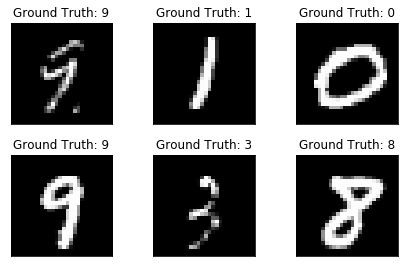

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
#fig

In [8]:
example_data[1][0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class Simple_Net(nn.Module):
    def __init__(self):
        super(Simple_Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [0]:
simple_network = Simple_Net()
optimizer = optim.SGD(simple_network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(network, optimizer, epoch, train_losses, train_counter, print_info = True):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      if print_info:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

In [0]:
def test(network, test_losses):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:
%%time
test(simple_network, test_losses)
for epoch in range(1, n_epochs + 1):
  train(simple_network, optimizer, epoch, train_losses, train_counter, True)
  test(simple_network, test_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3125, Accuracy: 956/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326879
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.258109
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.202709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.147442
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.063583
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.903328
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.841947
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.682471
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.668780
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.375327
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.070279
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.998452
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.982937
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.073038
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.676593
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.733126
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.657221
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.734516
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.598881
Train Epoch: 1 [12160/

Text(0, 0.5, 'negative log likelihood loss')

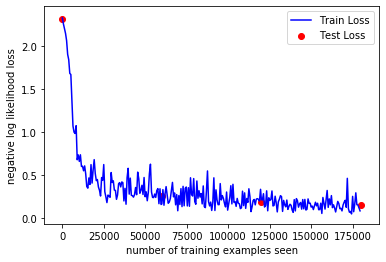

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [21]:
with torch.no_grad():
  output = simple_network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


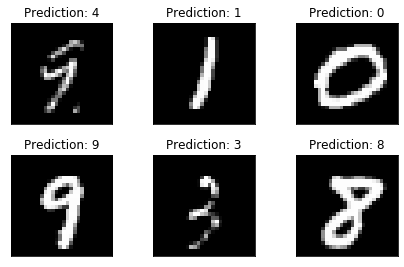

In [22]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [0]:
bad = [i for  i in range(1000) if output.data.max(1, keepdim=True)[1][i].item() != example_targets[i]]

In [32]:
len(bad)

34

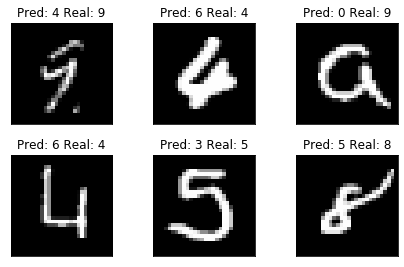

In [33]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[bad[i]][0], cmap='gray', interpolation='none')
  plt.title("Pred: {} Real: {}".format(
    output.data.max(1, keepdim=True)[1][bad[i]].item(), example_targets[bad[i]]))
  plt.xticks([])
  plt.yticks([])

In [0]:
continued_network = Simple_Net()
continued_optimizer = optim.SGD(continued_network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [0]:
network_state_dict = torch.load("model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [28]:
%%time
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(continued_network, continued_optimizer, i, train_losses, train_counter, False)
  test(continued_network, test_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1284, Accuracy: 9621/10000 (96%)


Test set: Avg. loss: 0.1154, Accuracy: 9658/10000 (97%)


Test set: Avg. loss: 0.1021, Accuracy: 9693/10000 (97%)


Test set: Avg. loss: 0.0933, Accuracy: 9716/10000 (97%)


Test set: Avg. loss: 0.0875, Accuracy: 9738/10000 (97%)

CPU times: user 57.4 s, sys: 1.41 s, total: 58.8 s
Wall time: 1min


In [29]:
%%time
for i in range(9,14):
  test_counter.append(i*len(train_loader.dataset))
  train(continued_network, continued_optimizer, i, train_losses, train_counter, False)
  test(continued_network, test_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0831, Accuracy: 9759/10000 (98%)


Test set: Avg. loss: 0.0794, Accuracy: 9748/10000 (97%)


Test set: Avg. loss: 0.0791, Accuracy: 9750/10000 (98%)


Test set: Avg. loss: 0.0732, Accuracy: 9771/10000 (98%)


Test set: Avg. loss: 0.0720, Accuracy: 9782/10000 (98%)

CPU times: user 56.4 s, sys: 1.36 s, total: 57.7 s
Wall time: 59.2 s


Text(0, 0.5, 'negative log likelihood loss')

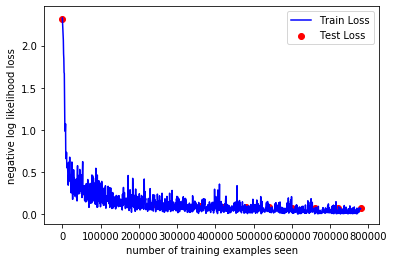

In [30]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [0]:
conv_network = Net()
optimizer = optim.SGD(conv_network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [0]:
conv_train_losses = []
conv_train_counter = []
conv_test_losses = []
conv_test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [37]:
%%time
test(conv_network, conv_test_losses)
for epoch in range(1, n_epochs + 1):
  train(conv_network, optimizer, epoch, conv_train_losses, conv_train_counter, True)
  test(conv_network, conv_test_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3165, Accuracy: 879/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.341102
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.309179
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.273582
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.289732
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.279036
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.218187
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.214216
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.185390
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.070787
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.181386
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.084263
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.040245
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.798337
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.728853
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.727016
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.665413
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.474264
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.556467
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.289984
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

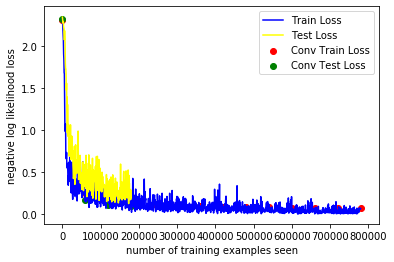

In [38]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.plot(conv_train_counter, conv_train_losses, color='yellow')
plt.scatter(conv_test_counter, conv_test_losses, color='green')
plt.legend(['Train Loss', 'Test Loss', 'Conv Train Loss', 'Conv Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')